In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from sklearn import metrics
from keras.models import load_model
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [32]:
img_width, img_height = 120, 160

train_data_dir = '../input/train-test/train_test_binary_data/train'
#validation_data_dir = '../input/binary-wbc/binary_data/validation'
test_data_dir = '../input/train-test/train_test_binary_data/test'
nb_train_samples = 9920
nb_validation_samples = 2483
epochs = 30
batch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
    #vertical_flip=True
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [34]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    #color_mode="grayscale")

Found 9920 images belonging to 2 classes.


In [35]:
#valid_batches = test_datagen.flow_from_directory(
    #validation_data_dir,
    #target_size=(img_width, img_height),
    #batch_size=batch_size,
    #classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    #color_mode="grayscale")

In [36]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=2483,
    classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    #color_mode="grayscale")

Found 2483 images belonging to 2 classes.


In [37]:
#train_batches = ImageDataGenerator().flow_from_directory(directory=train_data_dir, target_size=(150,150), classes=['MONONUCLEAR', 'POLYNUCLEAR'], batch_size=batch_size)
#valid_batches = ImageDataGenerator().flow_from_directory(directory=validation_data_dir, target_size=(150,150), classes=['MONONUCLEAR', 'POLYNUCLEAR'], batch_size=batch_size)
#test_batches = ImageDataGenerator().flow_from_directory(directory=test_data_dir, target_size=(150,150), classes=['MONONUCLEAR', 'POLYNUCLEAR'], batch_size=400, shuffle=False)

In [70]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

In [71]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [72]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [73]:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [74]:
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [75]:
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dense(64))
#model.add(Activation('relu'))
model.add(Dropout(0.4))
#model.add(Dense(32))
#model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [76]:
%%time
h = model.fit_generator(
    train_batches,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_batches,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[
       # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
        tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ])

Epoch 1/30
310/310 [==============================] - 71s 229ms/step - loss: 0.7080 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5022
Epoch 2/30
310/310 [==============================] - 71s 230ms/step - loss: 0.6902 - accuracy: 0.5458 - val_loss: 0.6717 - val_accuracy: 0.5191
Epoch 3/30
310/310 [==============================] - 70s 226ms/step - loss: 0.6858 - accuracy: 0.5433 - val_loss: 0.5396 - val_accuracy: 0.8087
Epoch 4/30
310/310 [==============================] - 71s 228ms/step - loss: 0.4626 - accuracy: 0.7807 - val_loss: 0.1816 - val_accuracy: 0.9331
Epoch 5/30
310/310 [==============================] - 71s 228ms/step - loss: 0.2307 - accuracy: 0.9199 - val_loss: 0.0972 - val_accuracy: 0.9702
Epoch 6/30
310/310 [==============================] - 72s 233ms/step - loss: 0.1574 - accuracy: 0.9452 - val_loss: 0.1410 - val_accuracy: 0.9364
Epoch 7/30
310/310 [==============================] - 71s 228ms/step - loss: 0.1867 - accuracy: 0.9582 - val_loss: 0.3044 - val_ac

In [79]:
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, rows=50, titles=test_labels)

In [80]:
#test_labels = test_labels[:,0]
rounded_labels = np.argmax(test_labels, axis=-1)
#test_labels

In [81]:
test_model = load_model('./model_0.978.h5')

In [82]:
predictions = test_model.predict_generator(test_batches, steps=1, verbose=0)

In [83]:
predictions

array([[0.99741983, 0.00258011],
       [0.02007447, 0.97992545],
       [0.01440042, 0.98559964],
       ...,
       [0.15806149, 0.8419385 ],
       [0.15851933, 0.8414807 ],
       [0.49069577, 0.5093042 ]], dtype=float32)

In [84]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [85]:
for i in rounded_prediction:
    print(i)

0
1
1
0
0
0
0
0
1
1
0
1
0
1
0
1
0
1
0
1
1
1
1
1
0
0
0
0
1
0
1
1
0
0
0
1
0
0
1
1
0
1
0
1
1
0
0
1
0
1
0
0
0
0
1
0
0
1
0
1
0
1
1
1
0
0
1
0
1
0
1
0
0
1
0
0
0
1
1
1
1
1
1
0
1
0
1
0
1
1
1
1
0
1
0
0
1
1
0
0
0
1
1
0
0
0
1
0
1
1
1
0
1
0
1
0
0
1
1
0
1
0
1
1
0
1
1
0
1
0
0
0
0
1
0
1
1
1
0
1
0
0
0
0
0
0
1
1
1
1
0
1
1
1
0
0
0
0
0
1
0
1
0
1
0
0
0
0
1
0
1
0
0
1
0
1
1
0
1
1
0
1
1
0
0
0
0
0
0
0
1
1
1
0
1
0
1
0
0
0
1
0
0
1
1
1
1
1
1
0
0
1
1
0
1
0
1
1
0
1
1
0
1
0
0
0
0
1
0
0
0
1
0
0
1
0
1
0
1
0
1
0
0
0
1
1
0
0
1
0
1
1
0
0
1
1
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
1
0
0
1
0
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
1
1
0
0
1
0
1
0
1
0
1
0
0
0
1
0
1
1
1
1
0
1
1
1
0
1
0
0
1
1
1
1
0
0
0
0
1
0
0
1
0
1
0
1
1
1
1
1
0
0
0
1
0
1
0
0
1
1
0
0
0
1
0
0
1
1
1
1
1
0
1
0
0
0
1
0
1
1
1
0
1
1
1
1
0
0
0
1
0
1
0
0
1
1
1
0
1
0
0
0
0
1
1
0
0
0
0
1
0
1
0
0
1
1
1
0
1
0
0
0
0
0
1
1
0
1
1
0
0
0
1
1
0
0
1
0
0
0
1
0
0
1
0
0
1
0
1
0
0
0
0
1
1
0
0
1
1
0
1
0
0
0
0
0
0
0
1
0
1
1
1
0
0
1
1
1
0
1
1
0
0
1
1
1
1
0
0
1
0
0
0
1
0
0
1
0
0
1


In [86]:
cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_prediction)

In [87]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1208   28]
 [  27 1220]]


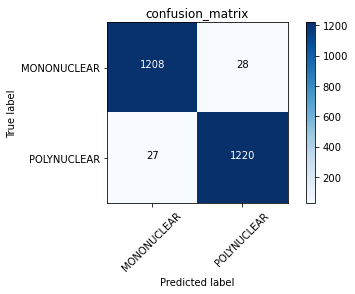

In [88]:
cm_plot_labels = ['MONONUCLEAR', 'POLYNUCLEAR']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')

In [89]:
#confusion matrix-->correct identification = 1208+1220= 2428
#                -->wrong identification = 28+27 = 55
#                --> accuracy = 2428/(2428 + 55) = 0.9778 or (97.78% accuracy)

In [90]:
from sklearn.metrics import classification_report

In [91]:
print(classification_report(y_true=rounded_labels, y_pred=rounded_prediction))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1236
           1       0.98      0.98      0.98      1247

    accuracy                           0.98      2483
   macro avg       0.98      0.98      0.98      2483
weighted avg       0.98      0.98      0.98      2483



In [92]:
def plot_roc(rounded_prediction,rounded_labels):
    fpr, tpr, _ = roc_curve(rounded_prediction,rounded_labels)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics (ROC)')
    plt.legend(loc='lower right')
    plt.show()

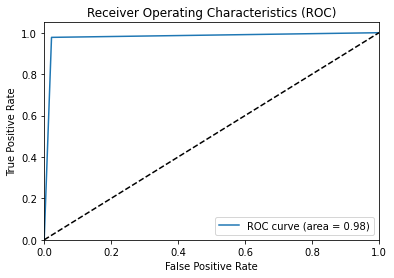

In [93]:
plot_roc(rounded_prediction,rounded_labels)

In [94]:
score = metrics.log_loss(rounded_labels,rounded_prediction)
print("Log loss score: {}".format(score))

Log loss score: 0.7650644746065789


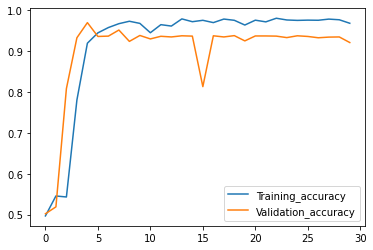

In [95]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.legend()
plt.show()

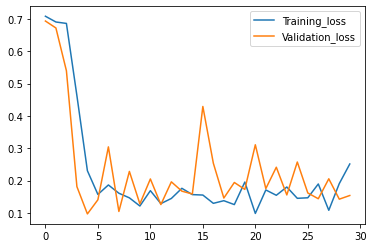

In [96]:
accs = h.history['loss']
val_accs = h.history['val_loss']

plt.plot(range(len(accs)),accs, label = 'Training_loss')
plt.plot(range(len(accs)),val_accs, label = 'Validation_loss')
plt.legend()
plt.show()